# Conditional GAN: cGAN


O notebook `BasicGAN.ipynb` implementou uma GAN usual, não-condicional, que não controlava o tipo de vestimenta que era gerado. Além disso, os resultados foram interessantes. Vamos apresentar uma cGAN para o FashionMNIST. Ele possui 10 classes de vestimenta. Vamos condicionar o tipo de vestimenta a ser gerado.

A rede do discriminador vai usar como entrada um par de inputs: uma imagem e o rótulo de sua classe (um dos 10 tipos de objetos do FashionMNIST). Isto significa que precisamos definir um modelo que recebe múltiplas (duas) entradas.

In [22]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as T

from tqdm.notebook import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


Definindo hiperparâmetros a serem utilizados.

In [5]:
img_size = 28
num_channels = 1
latent_size = 100

num_epochs = 50
batch_size = 64
learning_rate = 2e-4

num_classes = 10

## Definindo o discriminador

Tipicamente, em um discriminador convolucional, o bloco convolucional definido como `Conv - BatchNorm - LeakyReLU` é amplamente utilizado. Aqui, definimos uma classe para tornar esse bloco reutilizável ao longo da rede.

In [7]:
class DiscriminatorConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, **kwargs):
        super().__init__()
        
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.block(x)
        

class Discriminator(nn.Module):
    def __init__(self, in_channels: int = 1):
        super().__init__()

        self.label_embedding = nn.Sequential(
            nn.Embedding(num_classes, img_size * img_size),
            nn.Unflatten(1, (1, img_size, img_size))
        )

        self.backbone = nn.Sequential(
            DiscriminatorConvBlock(in_channels + 1, 64, kernel_size=4, stride=2, padding=1),
            DiscriminatorConvBlock(64, 128, kernel_size=4, stride=2, padding=1),
            DiscriminatorConvBlock(128, 256, kernel_size=4, stride=2, padding=1),
            DiscriminatorConvBlock(256, 512, kernel_size=3, stride=1, padding=1),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 3 * 3, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 1)
        )
        
    def forward(self, x, labels):
        label_embedding = self.label_embedding(labels)
        x = torch.cat((x, label_embedding), dim=1)

        x = self.backbone(x)
        return self.classifier(x)

In [14]:
discriminator = Discriminator().to(device)

# Passando um dado aleatório pela rede para ver se tudo está correto
x = torch.randn(8, 1, 28, 28).to(device)
labels = torch.randint(0, 10, size=(8,)).to(device)

outputs = discriminator(x, labels)
outputs.shape

torch.Size([8, 1])

## Notas do discriminador
###  How to Handle Continuous Conditioning Variables?

If the conditioning variable is continuous instead of discrete class labels (e.g., an age value, a temperature, or any real-valued number), then using nn.Embedding is not feasible because embeddings work by mapping discrete indices to vectors. Instead, we need a different approach to incorporate continuous conditioning variables into a Conditional GAN (cGAN).

Instead, you should:
- Concatenate the continuous condition directly to the latent space (z) and image inputs.
- Use an MLP to encode the condition into a feature vector before using it.

For simple conditions (e.g., one number like "age"), concatenation works fine.
For complex conditions (e.g., a high-dimensional continuous vector), an MLP-based approach is better.

We will not discuss further the continuous conditioning variable case in this notebook

## Definindo o gerador

O objetivo do gerador é de gerar uma imagem realista, similar àquelas do dataset utilizado, a partir de um ruído aleatório $z$.


O ruído aleatório $z \sim N(0,1)$ será um vetor unidimensional. Sendo assim, precisaremos utilizar uma série de convoluções transpostas para realizar um _upsampling_ para o tamanho da imagem original.

> Note que iremos utilizar uma outra camada de `Embedding` no gerador, que não está conectada com a utilizada pelo discriminador.

In [16]:
class Generator(nn.Module):
    def __init__(self, num_channels: int = 1, latent_size: int = 128):
        super().__init__()

        self.label_embedding = nn.Embedding(num_classes, latent_size)

        self.input_layer = nn.Sequential(
            nn.Linear(2 * latent_size, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (128, 7, 7))
        )

        self.upsampling_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2)
        )

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(32, num_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x, labels):
        label_embedding = self.label_embedding(labels)
        x = torch.cat([x, label_embedding], dim=1)
        
        x = self.input_layer(x)
        x = self.upsampling_layers(x)
        return self.final_layer(x)

In [18]:
generator = Generator(latent_size=latent_size).to(device)

# Passando um dado aleatório pela rede para ver se tudo está correto
x = torch.randn(8, latent_size).to(device)
labels = torch.randint(0, 10, size=(8,)).to(device)

outputs = generator(x, labels)
outputs.shape

torch.Size([8, 1, 28, 28])

## Treinamento da rede

In [19]:
def visualize_generated_images(generator, latent_dim, device, n_rows=2, n_cols=5):
    """
    Visualizes randomly generated images in a table format using the current parameters of the generator
    n_rows and n_cols are the numbers of rows and columns in the table of plots
    """
    generator.eval()  # Set generator to evaluation mode
    n_rows = n_rows
    n_cols = n_cols

    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for i in range(n_rows):
        # Generate noise
        noise = torch.randn(n_cols, latent_dim).to(device)
        labels = torch.randint(low=0, high=num_classes, size=(n_cols,)).to(device)

        # Generate images
        with torch.no_grad():
            gen_imgs = generator(noise, labels).cpu()

        # Plot images
        for j in range(n_cols):
            ax = plt.subplot(n_rows, n_cols, i * n_cols + j + 1)
            plt.imshow(gen_imgs[j].squeeze(), cmap="gray")
            plt.axis("off")
            if j == 0:
                plt.title(f"FashionMNIST")

    plt.tight_layout()
    plt.show()

In [23]:
in_channels = 1
latent_size = 100

num_workers = 2
batch_size = 64
num_epochs = 50
learning_rate = 2e-4

plot_frequency = 10  # plot every N epochs

transforms = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize([0.5], [0.5])  # range [-1, 1] costuma funcionar melhor
])

fmnist_datapath = '/pgeoprj2/ciag2024/dados/'
dataset = datasets.FashionMNIST(fmnist_datapath, train=True, transform=transforms, download=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

discriminator = Discriminator(in_channels).to(device)
generator = Generator(in_channels, latent_size).to(device)

criterion = nn.BCEWithLogitsLoss()
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14821a5343a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14821a5343a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/938 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14821a5343a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14821a5343a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

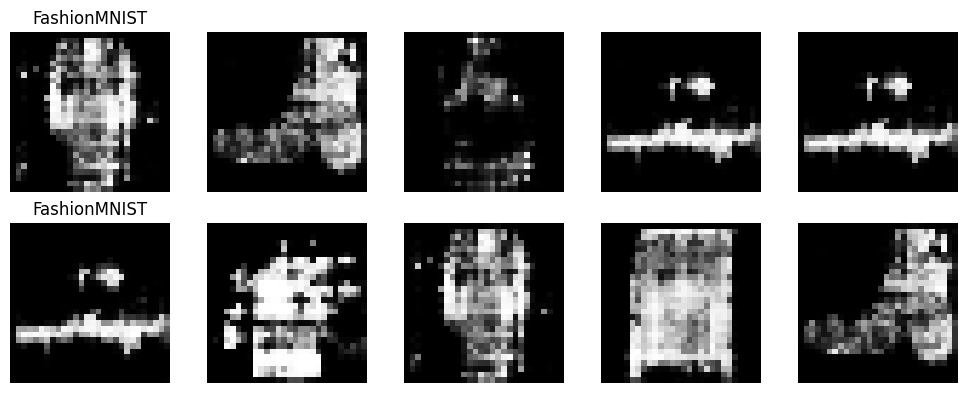

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

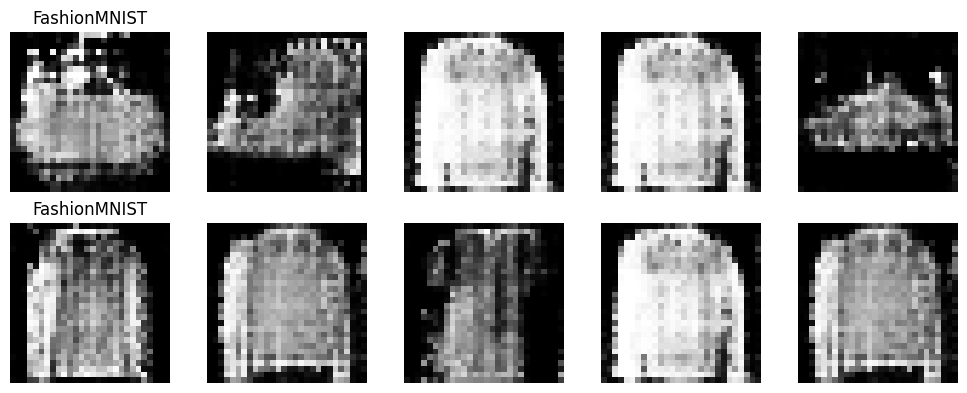

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

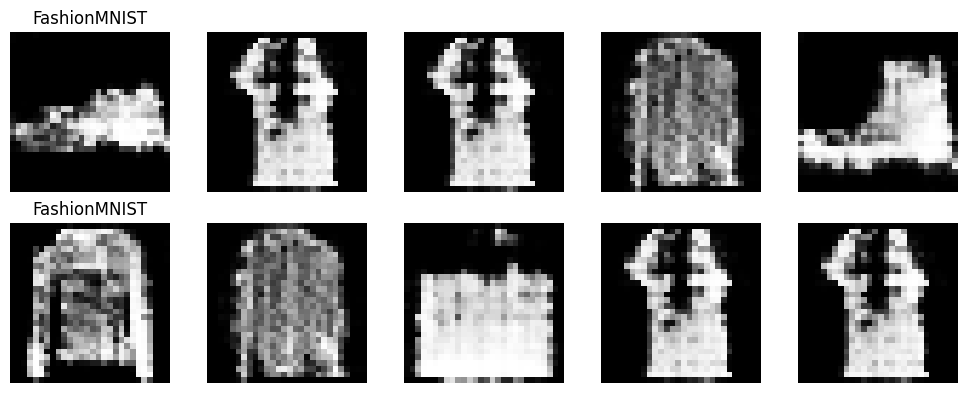

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

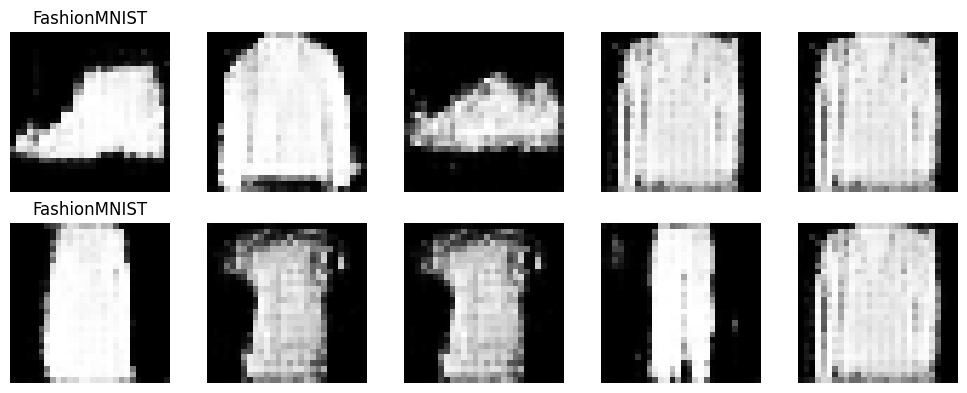

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

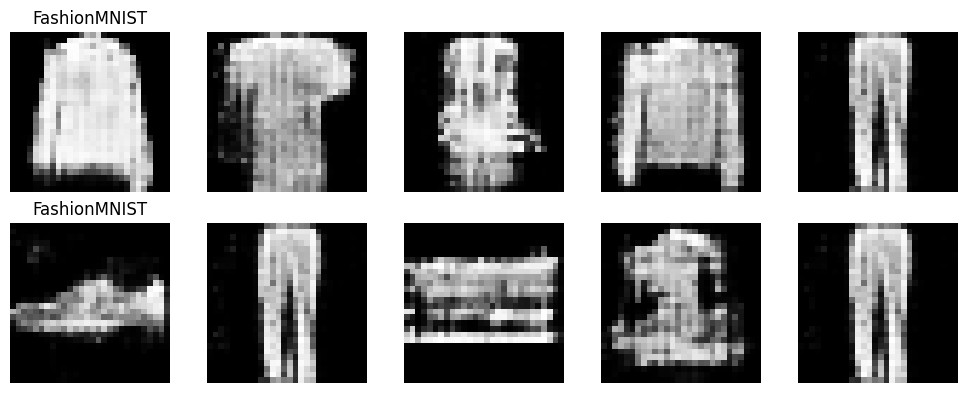

In [26]:
for epoch in range(num_epochs):
    d_train_loss = 0.0
    g_train_loss = 0.0

    for i, (real_imgs, labels) in (
            pbar := tqdm(enumerate(dataloader), total=len(dataloader), unit='batch')
        ):
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)
        
        # Definindo as labels reais (1) e fake (0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Treinamento do gerador
        g_optimizer.zero_grad()

        z = torch.randn(batch_size, latent_size).to(device)
        fake_imgs = generator(z, labels)

        g_loss = criterion(discriminator(fake_imgs, labels), real_labels)
        g_loss.backward()
        g_optimizer.step()

        # Treinamento do discriminador
        d_optimizer.zero_grad()

        real_loss = criterion(discriminator(real_imgs, labels), real_labels)
        fake_loss = criterion(discriminator(fake_imgs.detach(), labels), fake_labels)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        d_optimizer.step()

        # Store losses
        d_train_loss += d_loss.item()
        g_train_loss += g_loss.item()

        # Print progress
        pbar.set_description(
            f'Epoch {epoch+1}/{num_epochs} G_Loss: {g_train_loss/((i+1)):.4f} D_Loss: {d_train_loss/(i+1):.4f}'
        )

    # Visualize generated images every 10 epochs
    if (epoch+1) % plot_frequency == 0:
        visualize_generated_images(generator, latent_size, device, n_rows=2, n_cols=5)

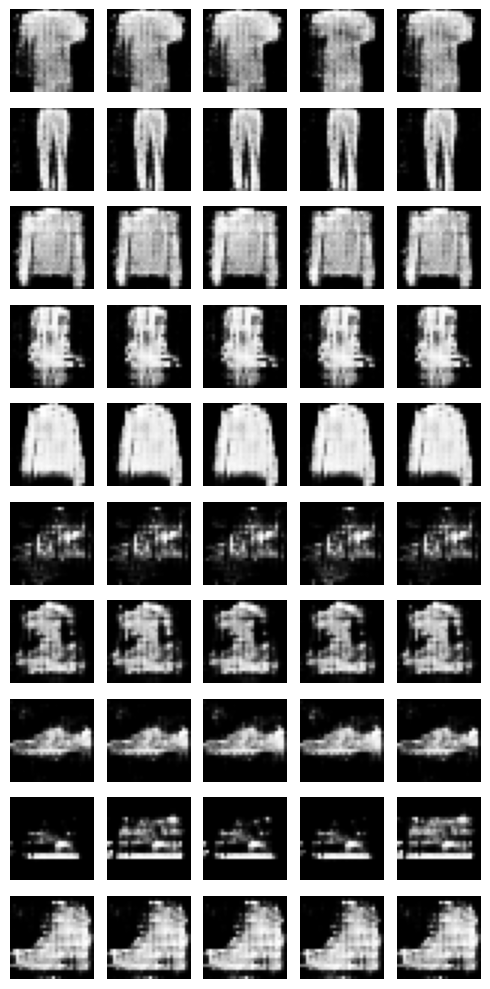

In [27]:
def generate_fixed_class_images(generator, latent_size, num_classes, device, n_rows=10, n_cols=5):
    generator.eval()  # Set to evaluation mode
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))  # Create grid

    with torch.no_grad():
        for class_idx in range(n_rows):  # Each row corresponds to a fixed class
            z = torch.randn(n_cols, latent_size).to(device)  # Generate different noise vectors
            labels = torch.full((n_cols,), class_idx, dtype=torch.long).to(device)  # Fixed class labels
            gen_imgs = generator(z, labels).cpu()  # Generate images

            for col in range(n_cols):
                axes[class_idx, col].imshow(gen_imgs[col].squeeze(), cmap="gray")
                axes[class_idx, col].axis("off")  # Hide axes

    plt.tight_layout()
    plt.show()

# Generate images with fixed class rows
generate_fixed_class_images(generator, latent_size, num_classes, device, n_rows=10, n_cols=5)